1. Train the Supervised Model:
   - Use historical data to train a SupervisedPricingModel to predict utilization based on features such as time of day, day of the week, special events, etc.
   - This model should output a prediction of utilization rates for different pricing scenarios, which the RL agent can use to predict revenue outcomes.


2. Setup the RL Environment:

   - The environment (PricingEnvironment) should encapsulate the state of the car rental market (based on features) and provide feedback (reward) to the RL agent based on the actions it takes (i.e., changing prices).
   - The state could include current utilization, current price, time information.
   - The reward should be calculated based on the utilization rate predicted by the supervised model and the price set by the agent, essentially reward = price × predicted utilization.


3. Implement the RL Agent:

   - The RL agent uses strategies epsilon-greedy and ABN to explore different pricing actions and learn which strategies yield the highest rewards.
   - Over time, the agent should learn to balance exploration (testing new prices) and exploitation (using prices known to maximize revenue).

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from collections import defaultdict
from sklearn.ensemble import GradientBoostingRegressor
from collections import deque

#!pip install openpyxl

## 1. Preprocessing

In [2]:
# 1. Data Processing

# is_holiday
def is_holiday(date):
    """
    Check if a given date is a holiday in 2017
    """
    holidays_2017 = {
        '2017-01-01': 'New Year\'s Day',
        '2017-01-02': 'New Year\'s Day (observed)',
        '2017-01-16': 'Martin Luther King Jr. Day',
        '2017-02-20': 'Presidents\' Day',
        '2017-05-29': 'Memorial Day',
        '2017-07-04': 'Independence Day',
        '2017-09-04': 'Labor Day',
        '2017-10-09': 'Columbus Day',
        '2017-11-10': 'Veterans Day (observed)',
        '2017-11-11': 'Veterans Day',
        '2017-11-23': 'Thanksgiving Day',
        '2017-11-24': 'Day after Thanksgiving',
        '2017-12-25': 'Christmas Day'
    }

    date_str = date.strftime('%Y-%m-%d')
    return date_str in holidays_2017

def load_and_process_data(utilization_path, journey_path, city=''):
    """
    Load and process the utilization and journey datasets
    """
    # Load datasets
    utilization_df = pd.read_csv(utilization_path)
    journey_df = pd.read_csv(journey_path, converters={'Car Parking Address Postcode': str})
    if city != '':
        journey_df = journey_df[journey_df['Car Parking Address City'] == city]
    else:
        journey_df = journey_df
#    print(journey_df.info())

    # Convert price columns to float
    journey_df['Trip Sum Trip Price'] = journey_df['Trip Sum Trip Price'].str.replace('$', '', regex=False).str.replace(
        ',', '').astype(float)

    # Convert timestamp columns to datetime
    journey_df['Trip Start At Local Time'] = pd.to_datetime(journey_df['Trip Start At Local Time'])
    journey_df['Car Hourly Utilization Aggregated At Time'] = journey_df['Trip Start At Local Time'].apply(
        lambda x: x.replace(minute=0, second=0))
    journey_df['Car Hourly Utilization Aggregated At Time'] = journey_df[
        'Car Hourly Utilization Aggregated At Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    journey_df['Trip End At Local Time'] = pd.to_datetime(journey_df['Trip End At Local Time'])
    journey_df['Trip Created At Local Time'] = pd.to_datetime(journey_df['Trip Created At Local Time'])


    # Calculate trip duration
    utilization_df = utilization_df.replace([np.inf, -np.inf], np.nan).dropna() #replace infinites and drop them
    journey_df['Duration'] = (journey_df['Trip End At Local Time'] -
                              journey_df['Trip Start At Local Time']).dt.total_seconds() / 3600 #converts the duration from seconds to hours.
    utilization_df['Utilization_Rate'] = (
            utilization_df['Car Hourly Utilization Sum Utilized Minutes'] /
            utilization_df['Car Hourly Utilization Sum Available Minutes']
    )
    utilization_df = utilization_df.replace([np.inf, -np.inf], np.nan).dropna() #replace infinites and drop nan
    
    # Drop rows where Utilization_Rate is greater than 1
    utilization_df = utilization_df[utilization_df['Utilization_Rate'] <= 1]

    merged_df = pd.merge(
        utilization_df,
        journey_df,
        on=['Car ID Hash', 'Car Hourly Utilization Aggregated At Time'],
        how='inner'
    )

    # Make a copy to avoid modifying original data
    df_features = merged_df.copy()

    # Time Features
    df_features['Hour'] = df_features['Trip Start At Local Time'].dt.hour
    df_features['Day'] = df_features['Trip Start At Local Time'].dt.dayofweek
    df_features['Month'] = df_features['Trip Start At Local Time'].dt.month
    df_features['DayOfMonth'] = df_features['Trip Start At Local Time'].dt.day
    df_features['Week'] = df_features['Trip Start At Local Time'].dt.isocalendar().week

    # Time Category
    df_features['TimeOfDay'] = pd.cut(
        df_features['Hour'],
        bins=[-1, 6, 12, 18, 23], #e.g Night: Hours greater than -1 and up to 6. This includes midnight to just before dawn (0-6).
        labels=['Night', 'Morning', 'Afternoon', 'Evening']
    )

    # Is weekend
    df_features['IsWeekend'] = df_features['Day'].isin([5, 6]).astype(int)
    # Is holiday
    df_features['IsHoliday'] = df_features['Trip Start At Local Time'].apply(is_holiday).astype(int)

    # 2. Demand features
    # caculate hourly bookings
    hourly_bookings = df_features.groupby([
        df_features['Trip Start At Local Time'].dt.date,
        df_features['Hour']
    ]).size().reset_index(name='HourlyBookings')
    df_features = pd.merge(
        df_features,
        hourly_bookings,
        left_on=[df_features['Trip Start At Local Time'].dt.date, 'Hour'],
        right_on=['Trip Start At Local Time', 'Hour'],
        how='inner'
    )

    # HourlyBookings # 7-Day Moving Average to smooth out short-term fluctuations
    df_features['MA7_Bookings'] = df_features.groupby('Hour')['HourlyBookings'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )

    # DurationType
    df_features['DurationType'] = pd.cut(
        df_features['Duration'],
        bins=[-float('inf'), 2, 4, 8, float('inf')],
        labels=['Short', 'Medium', 'Long', 'Extended'] #e.g. Medium: More than 2 hrs and up to 4 hrs
    )

    # 4. Price Feature
    hourly_avg_price = df_features.groupby('Hour')['Trip Sum Trip Price'].transform('mean')
    df_features['PriceToAvgRatio'] = df_features['Trip Sum Trip Price'] / hourly_avg_price
    #to understand how a particular trip's pricing compares to the typical pricing at that time
    #e.g. A PriceToAvgRatio of 1.1547 => the price of that specific trip is ~15.47% higher than the average price of all trips at the same hour.

    # Price trend
    df_features['DailyPriceTrend'] = df_features.groupby(
        df_features['Trip Start At Local Time_x'].dt.date
    )['Trip Sum Trip Price'].transform(lambda x: x.pct_change())
    #To compute the percentage change in trip prices from one trip to the next within the same day helps in identifying fluctuations over the course of a day.
    #A DailyPriceTrend value of -0.1724 => a decrease in the trip price by ~17.24% compared to the previous price recorded for the same day.

    # 5. Address Feature
    # PostcodeEncoded
    le = LabelEncoder()
    df_features['PostcodeEncoded'] = le.fit_transform(df_features['Car Parking Address Postcode'])

    # Calculate the average price for each zipcode
    postcode_avg_price = df_features.groupby('PostcodeEncoded')['Trip Sum Trip Price'].transform('mean')
    df_features['PostcodePriceRatio'] = df_features['Trip Sum Trip Price'] / postcode_avg_price

    # 6. Utiliazation Feature
    # Calculate 7-Day moving average utilization
    df_features['MA7_Utilization'] = df_features.groupby('Car ID Hash')['Utilization_Rate'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )

    # # Change in utilization
    # df_features['UtilizationChange'] = df_features.groupby('Car ID Hash')['Utilization_Rate'].transform(
    #     lambda x: x.pct_change()
    # )
    #a metric for monitoring and reacting to sudden changes in utilization
    #e.g. A UtilizationChange value of -0.25 => a decrease in utilization rate by 25% from one measurement period to the next for a specific car

    # 7. Competition characteristics (based on the number of vehicles in the same period)
    df_features['CompetingCars'] = df_features.groupby([
        df_features['Trip Start At Local Time_x'].dt.date,
        'Hour',
        'Car Parking Address Postcode'
    ])['Car ID Hash'].transform('count')
    #calculates the number of cars competing within the same zipcode and at the same time, providing a measure of competition/congestion

    # 8. Interaction Features for Weekend and Holiday Peaks
    df_features['WeekendPeak'] = ((df_features['IsWeekend'] == 1) &
                                  (df_features['Hour'].between(9, 18))).astype(int) #check if the 9 AM to 6 PM window sounds logical
    df_features['HolidayPeak'] = ((df_features['IsHoliday'] == 1) &
                                  (df_features['Hour'].between(9, 18))).astype(int)

    # 9. Stats details
    # Calculate the price statistical features for each time segment
    time_price_stats = df_features.groupby('TimeOfDay', observed=False)['Trip Sum Trip Price'].agg([
        'mean', 'std', 'min', 'max']).reset_index()


    # Merge
    df_features = pd.merge(
        df_features,
        time_price_stats,
        on='TimeOfDay', #for time-contextual insight
        how='left',
        suffixes=('', '_TimeOfDay')
    )
    print(df_features.info())

    # 10. Time differences feature
    df_features['BookingLeadTime'] = (df_features['Trip Start At Local Time_x'] - df_features[
        'Trip Created At Local Time']
                                      ).dt.total_seconds() / 3600

    # Create labels for reservation of cars
    df_features['BookingType'] = pd.cut(df_features['BookingLeadTime'],
                                        bins=[-float('inf'), 24, 72, 168, float('inf')],
                                        labels=['LastMinute', 'Short', 'Medium', 'LongTerm'])
    #LastMinute: Up to 24 hrs. Short: More than 24 hrs up to 72 hrs. Medium: More than 72 hrs up to 168 hrs (one week). LongTerm: More than 168 hrs.

    # Clean the data
    df_features = df_features.replace([np.inf, -np.inf], np.nan)
    df_features = df_features.ffill()

    df_features.to_excel('feature.xlsx', index=False)
    return df_features 

## 2. Supervised Learning Model

In [3]:
class SupervisedPricingModel:
    def __init__(self):
        # Initializing Gradient Boosting Regressor with tuned parameters
        self.model = GradientBoostingRegressor(
            loss='squared_error',  # Equivalent to the 'reg:squarederror' in XGBoost
            n_estimators=150,      # Same number of trees
            max_depth=7,           # Same depth for individual trees
            learning_rate=0.05,    # Same learning rate for gradual enhancements
            subsample=0.8,         # Same strategy for stochastic gradient boosting
            random_state=42        # Ensures reproducibility
        )
        self.feature_importances = None

    def prepare_features(self, df):
        features = df[['Hour', 'Month', 'Duration', 'IsWeekend', 
                       'MA7_Bookings', 'PriceToAvgRatio', 'PostcodePriceRatio',
                       'CompetingCars', 'BookingLeadTime', 'PostcodeEncoded']]
        target = df['Utilization_Rate']
        return features, target

    def train(self, df):
        X, y = self.prepare_features(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.model.fit(X_train, y_train)
        # Store feature importances after fitting the model
        self.feature_importances = pd.DataFrame({
            'feature': X.columns,
            'importance': self.model.feature_importances_
        }).sort_values(by='importance', ascending=False)
        return X_test, y_test

    def tune_hyperparameters(self, df):
        X, y = self.prepare_features(df)
        param_grid = {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.7, 0.8, 0.9],
            'n_estimators': [100, 150, 200]
        }
        grid_search = GridSearchCV(estimator=self.model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        return grid_search.best_params_

    def get_feature_importances(self):
        if self.feature_importances is not None:
            return self.feature_importances
        else:
            return "Feature importances are not available yet."

    def predict(self, features):
        return self.model.predict(features)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        metrics = {
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        }
        return metrics

    def plot_results(self, X_test, y_test):
        y_pred = self.predict(X_test)
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Actual vs Predicted
        axes[0, 0].scatter(y_test, y_pred, alpha=0.5)
        axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        axes[0, 0].set_xlabel('Actual Utilization Rate')
        axes[0, 0].set_ylabel('Predicted Utilization Rate')
        axes[0, 0].set_title('Actual vs Predicted Utilization Rates')

        # Residuals plot
        residuals = y_test - y_pred
        axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
        axes[0, 1].axhline(y=0, color='r', linestyle='--')
        axes[0, 1].set_xlabel('Predicted Utilization Rate')
        axes[0, 1].set_ylabel('Residuals')
        axes[0, 1].set_title('Residuals vs Predicted Utilization Rates')

        # Feature importances
        if self.feature_importances is not None:
            sns.barplot(x='importance', y='feature', data=self.feature_importances, ax=axes[1, 0])
        else:
            axes[1, 0].text(0.5, 0.5, "Feature importances not available", ha='center')
        axes[1, 0].set_title('Feature Importances')
        axes[1, 0].set_xlabel('Importance')
        axes[1, 0].set_ylabel('Features')

        # Residuals histogram
        sns.histplot(residuals, ax=axes[1, 1], kde=True)
        axes[1, 1].set_title('Residual Distribution')
        plt.tight_layout()
        return fig

def Supervised_use(data):
    # Initialize and train model
    model = SupervisedPricingModel()
    X_test, y_test = model.train(data)
    # Get model evaluation metrics
    metrics = model.evaluate(X_test, y_test)
    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Get feature importances
    importances = model.get_feature_importances()
    print("\nFeature Importances:")
    print(importances)

    # Plot results
    fig = model.plot_results(X_test, y_test)
    plt.show()

    return model


In [4]:
# if __name__ == '__main__':
#     # Load data
#     data = load_and_process_data('utilization.csv', 'journeys.csv', city='San Francisco')

#     # Print data overview and checks
#     print("Number of entries in the dataset:", len(data))
#     print("\nMissing values in each column:")
#     print(data.isnull().sum())
#     print("\nDescriptive statistics of the data:")
#     print(data.describe())
#     print("\nSample data:")
#     print(data.head())

#     # Train model, Predict model
#     Supervised_use(data)

## 3. Reinforcement Learning

The objective is to develop a reinforcement learning agent capable of dynamically adjusting car rental prices based on utilization predictions. This involves learning a pricing policy that maximizes revenue by balancing between exploring new pricing strategies and exploiting known profitable strategies. Specific goals and scenarios:

- Maximize Revenue: The agent should find the optimal balance between high utilization and high pricing.
- Learn from Data: The model should adapt based on feedback from real-world interactions (or simulations thereof) and find the best pricing actions under varying conditions.
- Experimentation and Learning Balance: Utilize exploration to discover potentially better pricing decisions while exploiting known strategies to ensure profitability.

In [5]:
# 3. Reinforcement Learning Components
class State:
    def __init__(self, price, hour, duration):
        self.price = price
        self.hour = hour
        self.duration = duration

    def to_tuple(self):
        return self.price, self.hour, self.duration

class PricingEnvironment:
    def __init__(self, data, model):
        self.data = data
        self.model = model
        self.current_index = 0

    def get_state(self):
        current_row = self.data.iloc[self.current_index]
        return State(price=current_row['Trip Sum Trip Price'],
                     hour=current_row['Hour'],
                     duration=current_row['Duration'])

    def step(self, action):
        current_row = self.data.iloc[self.current_index]
        current_price = current_row['Trip Sum Trip Price']

        # Apply price adjustment based on the action
        if action == 'increase_price':
            new_price = current_price * 1.05
        elif action == 'decrease_price':
            new_price = current_price * 0.95
        else:
            new_price = current_price

        # Prepare features for the supervised model to predict utilization
        features_df = pd.DataFrame([[
            current_row['Hour'],
            current_row['Month'],
            current_row['Duration'],
            current_row['IsWeekend'],
            current_row['MA7_Bookings'],
            new_price / current_row['Trip Sum Trip Price'], # Calculating PriceToAvgRatio dynamically
            current_row['PostcodePriceRatio'],
            current_row['CompetingCars'],
            current_row['BookingLeadTime'],
            current_row['PostcodeEncoded']
        ]], columns=['Hour', 'Month', 'Duration', 'IsWeekend',
                     'MA7_Bookings', 'PriceToAvgRatio', 'PostcodePriceRatio',
                     'CompetingCars', 'BookingLeadTime', 'PostcodeEncoded'])

        # Predict utilization using the supervised model
        predicted_utilization = self.model.predict(features_df)[0]

        # Calculate reward based on predicted utilization
        reward = new_price * predicted_utilization

        # Move to next state
        self.current_index = (self.current_index + 1) % len(self.data)
        done = self.current_index == 0

        return self.get_state(), reward, done

In [6]:
# 4. Exploration Strategies

class EpsilonGreedyStrategy:
    def __init__(self, epsilon=0.1, decay=0.99, min_epsilon=0.01):
        self.epsilon = epsilon
        self.decay = decay
        self.min_epsilon = min_epsilon
        self.q_values = defaultdict(lambda: defaultdict(float))

    def select_action(self, state):
        """
        Select action using epsilon-greedy strategy, with decaying epsilon.
        """
        # Decay the epsilon value
        self.epsilon = max(self.min_epsilon, self.epsilon * self.decay)

        # Check if the state is explored
        state_tuple = state.to_tuple()
        state_values = self.q_values[state_tuple]

        # If state is unexplored or random roll is below epsilon, choose a random action
        if not state_values or random.random() < self.epsilon:
            action = random.choice(['increase_price', 'keep_price', 'decrease_price'])
        else:
            # Choose the best known action based on max Q-value
            action = max(state_values, key=state_values.get)

        return action

    def update(self, state, action, reward):
        """
        Update Q-values based on observed reward.
        """
        state_tuple = state.to_tuple()
        learning_rate = 0.1
        # Simple Q-value update
        old_value = self.q_values[state_tuple][action]
        new_value = (1 - learning_rate) * old_value + learning_rate * reward
        self.q_values[state_tuple][action] = new_value


class ABNStrategy:
    def __init__(self, n_variations=3):
        self.n_variations = n_variations
        self.rewards = defaultdict(list)

    def select_action(self, state):
        """
        Select action using A/B/N testing strategy
        """
        actions = ['increase_price', 'keep_price', 'decrease_price']
        if any(len(self.rewards[a]) < 10 for a in actions): #For sparse data, increase the threshold might be necessary to ensure statistical significance.
            return random.choice(actions)
        else:
            avg_rewards = {a: sum(self.rewards[a]) / len(self.rewards[a]) for a in actions}
            return max(avg_rewards.items(), key=lambda x: x[1])[0]

    def update(self, state, action, reward):
        """
        Update rewards history
        """
        self.rewards[action].append(reward)

# 5. Main Training Loop
def train_rl_agent(env, strategy, n_episodes=1000):
    """
    Train the reinforcement learning agent
    """
    total_rewards = []

    for episode in range(n_episodes):
        episode_reward = 0
        state = env.get_state()
        done = False

        while not done:
            action = strategy.select_action(state)
            next_state, reward, done = env.step(action)
            strategy.update(state, action, reward)
            episode_reward += reward
            state = next_state

        total_rewards.append(episode_reward)

    return total_rewards

# 6. Evaluation Function
def evaluate_strategy(env, strategy, n_episodes=100):
    """
    Evaluate the performance of a pricing strategy
    """
    total_rewards = []

    for _ in range(n_episodes):
        episode_reward = 0
        state = env.get_state()
        done = False

        while not done:
            action = strategy.select_action(state)
            _, reward, done = env.step(action)
            episode_reward += reward

        total_rewards.append(episode_reward)

    return np.mean(total_rewards), np.std(total_rewards)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35303 entries, 0 to 35302
Data columns (total 38 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   Trip Start At Local Time                      35303 non-null  object        
 1   Car ID Hash                                   35303 non-null  object        
 2   Car Hourly Utilization Aggregated At Time     35303 non-null  object        
 3   Car Hourly Utilization Sum Available Minutes  35303 non-null  float64       
 4   Car Hourly Utilization Sum Utilized Minutes   35303 non-null  float64       
 5   Utilization_Rate                              35303 non-null  float64       
 6   Trip ID Hash                                  35303 non-null  object        
 7   Car Parking Address Postcode                  35303 non-null  object        
 8   Car Parking Address City                      35303 non-null  obje

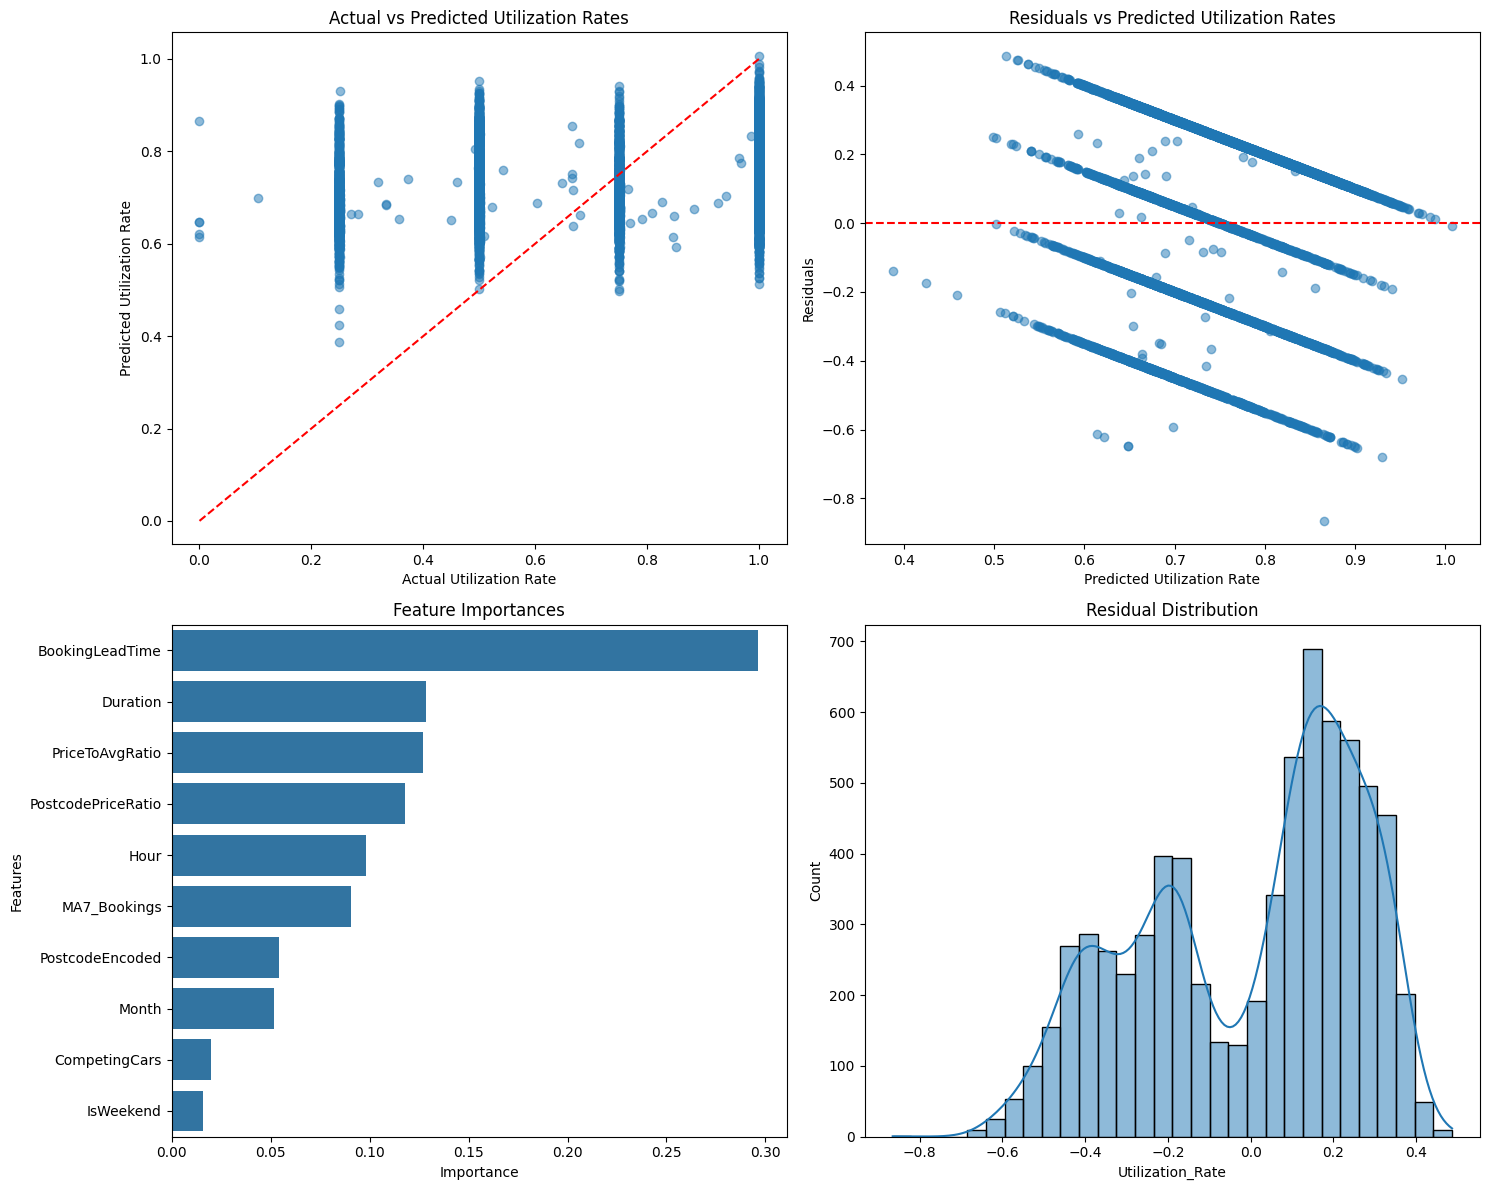

In [ ]:
if __name__ == '__main__':
    # Prepare the environment and strategies
    data = load_and_process_data('utilization.csv', 'journeys.csv', city='San Francisco')
    model_instance = Supervised_use(data)
    env = PricingEnvironment(data=data, model=model_instance)

    epsilon_strategy = EpsilonGreedyStrategy()
    abn_strategy = ABNStrategy()

    # Train both strategies
    epsilon_rewards = train_rl_agent(env, epsilon_strategy, 1000)
    abn_rewards = train_rl_agent(env, abn_strategy, 1000)
    # Evaluate both strategies
    epsilon_avg, epsilon_std = evaluate_strategy(env, epsilon_strategy, 100)
    abn_avg, abn_std = evaluate_strategy(env, abn_strategy, 100)

    print(f"Epsilon-Greedy Average Reward: {epsilon_avg}, Std Dev: {epsilon_std}")
    print(f"ABN Strategy Average Reward: {abn_avg}, Std Dev: {abn_std}")

In [ ]:
# Plotting the rewards for comparison
plt.figure(figsize=(12, 6))
plt.plot(epsilon_rewards, label='Epsilon-Greedy Rewards')
plt.plot(abn_rewards, label='A/B/N Strategy Rewards')
plt.title('Comparison of Strategy Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()